In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer

df = pd.read_csv("clean_song_data.csv")

In [4]:
#Ensure the lyrics col is in the same format: a string of ' ' separated words representing the lyrics of the song
for idx, row in df['lyrics'].items():
    if type(row) == tuple:
        df['lyrics'][idx] = row[1]


In [5]:
#print(df['lyrics'])
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words()

def clean_string(lyrics):
    if type(lyrics) == str:

        words = lyrics.split()
        sb = []
        p_stem = PorterStemmer()
        for word in words:
            if word not in stop_words:
                sb.append(p_stem.stem(word))

        return ' '.join(sb)
    else:
        return ""

def clean_dataset(df):
    df['lyrics'] = df['lyrics'].apply(clean_string)

    return df

df = clean_dataset(df)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\souls\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyboardInterrupt: 

In [78]:
df.to_csv('clean_song_data.csv')

In [4]:
print(df.shape)
def get_word_vec(lyrics):
    vector = []

    for i, word in lyrics.items():
        if (type(word) == str):
            split_words = word.split()
            vector.append(split_words)
        else:
            vector.append([])
    
    return vector

split_word_list = get_word_vec(df['lyrics'])
print(len(split_word_list))

(210126, 7)
210126


In [56]:
model = word2vec.Word2Vec(split_word_list, min_count=500)

In [54]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.key_to_index:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tokens = np.array(tokens)
    labels = np.array(labels)
    print(tokens.shape)
    print(labels.shape)
    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2500, random_state=23)

    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

(287, 100)
(287,)


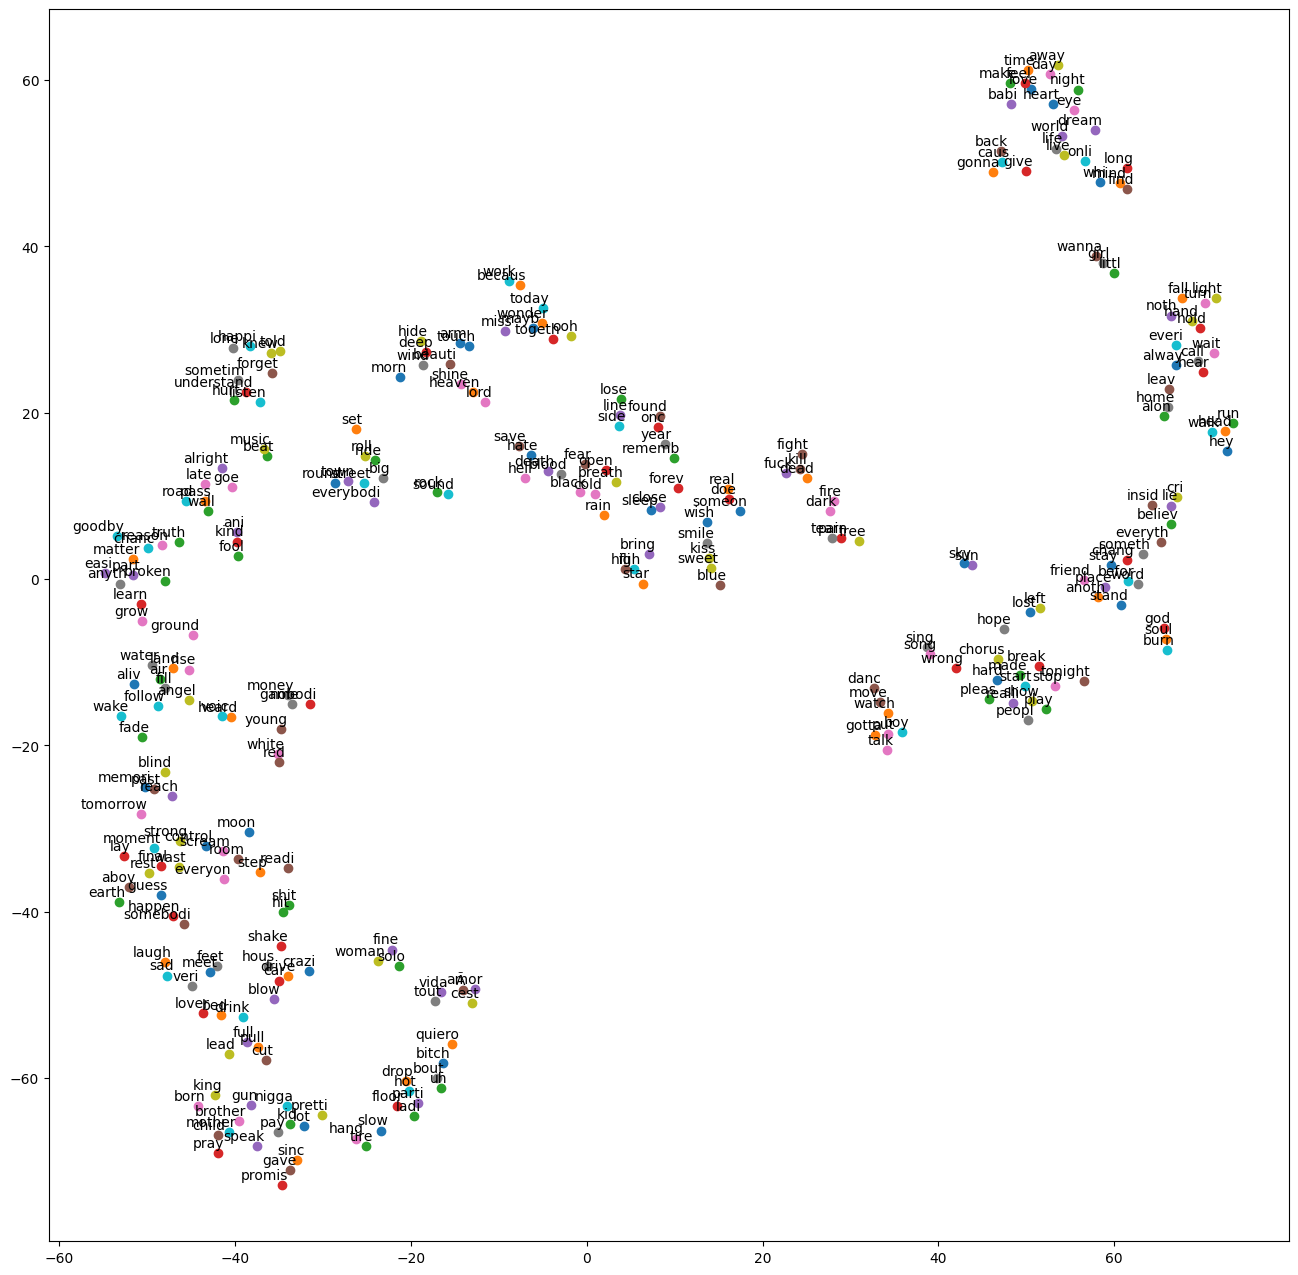

In [55]:
#Plot representations of words in model
tsne_plot(model)

In [57]:
#Save model
model.save("word2vec.model")

In [10]:
df = df.drop('Unnamed: 0.1', axis='columns')
df = df.drop('Unnamed: 0', axis='columns')


Index(['track_id', 'mxm_id', 'words_count', 'title', 'artist_name', 'lyrics'], dtype='object')


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Constructing TFIDF term frequency matrix
tfidf = TfidfVectorizer()
df['lyrics'].fillna('', inplace=True)
doc_term_matrix = tfidf.fit_transform(df['lyrics'])
doc_term_matrix = doc_term_matrix.T



In [7]:
from scipy.sparse.linalg import svds
#Apply SVD to the matrix
#Takes significant time
#There are abour 4000 vocab words in doc term matrix
u, s, vt = svds(doc_term_matrix, k=1000)

        

In [8]:
#Get the term and song representations from SVD
terms_rep = np.dot(u, np.diag(s))

song_rep = np.dot(np.diag(s), vt).T

In [9]:
from nltk.tokenize import RegexpTokenizer
#Preprocessing query to remove stop words and make words base form
stop_words = nltk.corpus.stopwords.words()

def preprocess_query(query_lyrics):
    if type(query_lyrics) == str:
        tokenizer = RegexpTokenizer(r'[a-z]+')
        words = tokenizer.tokenize(query_lyrics.lower())

        sb = []
        p_stem = PorterStemmer()
        for word in words:
            if word not in stop_words:
                sb.append(p_stem.stem(word))

        return ' '.join(sb)
    else:
        return ""

In [10]:
#Find the lsa query representation
def lsa_query_rep(query):
    query = preprocess_query(query)
    query_rep = [tfidf.vocabulary_[w] for w in query.split() if w in tfidf.vocabulary_ ]
    query_rep = np.mean(song_rep[query_rep], axis=0)

    return query_rep

In [11]:
from scipy.spatial.distance import cosine
#Find the most similar songs based on a string query
#Returns a tuple containing each song id, song name, and artist name
def find_similar_songs(df, query, num_songs=10):
    query_rep = lsa_query_rep(query)
    query_song_cos_dist = [cosine(query_rep, s_rep) for s_rep in song_rep]
    query_song_sort_idx = np.argsort(np.array(query_song_cos_dist))
    similar_songs = []

    i = 0
    while num_songs > 0:
        df_idx = query_song_sort_idx[i]
        
        #Exclude zero cos dist values, calculation may have had errors
        if query_song_cos_dist[df_idx] != 0 :
            similar_songs.append((df['track_id'][df_idx], df['title'][df_idx], df['artist_name'][df_idx]))
            num_songs -= 1
        
        i += 1

    return similar_songs

In [58]:
with open('test_song.txt', 'r') as file:
    test_query = file.read()

find_similar_songs(df, test_query)


Song:  Living In Misery
Artist:  Kill Hannah
0.7359187548380312
Song:  Only Happy When It Rains (Re-mastered 2007)
Artist:  Garbage
0.6896615524460517
Song:  Misery
Artist:  Wayne Hancock
0.6724369407090988
Song:  Misery
Artist:  Good Charlotte
0.6681532411981206
Song:  In Death
Artist:  Virgin Black
0.6482626250514043
Song:  Sweet Misery
Artist:  Amel Larrieux
0.6393444522904963
Song:  Misery
Artist:  Arise
0.636270649156506
Song:  Doll Fin
Artist:  Reuben
0.6348714421644722
Song:  Valerie (2003 Digital Remaster)
Artist:  Philip Oakey & Giorgio Moroder
0.6211657177564397
Song:  My Friend Of Misery
Artist:  Apocalyptica
0.607819459694608
Song:  1000 Umbrellas (2001 Digital Remaster)
Artist:  XTC
0.5830378723159805
Song:  Misery
Artist:  The Moffatts
0.5694361401775788
Song:  Love Is Misery
Artist:  Before Their Eyes
0.5636068612529914
Song:  Misery
Artist:  BoDeans
0.5466772904142587
Song:  Product Of Misery
Artist:  Cyndi Lauper
0.5465031502248209
Song:  Misery
Artist:  Bumblefoot
0.5

In [28]:
evaluation_df = pd.read_csv("eval_similar_songs.csv")

In [29]:
import test

#Compute similar songs for a given song based on lyrics
#Returns the 10 most similar ids, track names, and artist names
def evaluate_row(df_row):
    #Find Similar Songs returns a list of tuples in the format (song id, song name, artist name)
    similar_songs = find_similar_songs(df, df_row['lyrics'], 10)
    df_row['pred_song_ids'] = []
    df_row['pred_song_names'] = []
    df_row['pred_artist_names'] = []

    for song in similar_songs:
        df_row['pred_song_ids'].append(song[0])
        df_row['pred_song_names'].append(song[1])
        df_row['pred_artist_names'].append(song[2])
        
    return df_row


evaluation_df = evaluation_df.apply(evaluate_row, axis=1)
evaluation_df


c:\Python312\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Python312\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Python312\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Python312\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Python312\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Python312\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Python312\Lib\site-packages\scipy\spa

,track_id,mxm_id,words_count,title,artist_name,lyrics,target,pred_song_ids,pred_song_names,pred_artist_names
0,TRAAGJV128F1464090,6622168,"['1:21', '2:2', '3:10', '4:22', '5:6', '6:2', ...",It's My Party,Lesley Gore,i i i i i i i i i i i i i i i i i i i i i the ...,"TRDRFLI128F92C94CB,TRQQEEF128F92D5BC4,TRBTMXC1...","[TRACJWY12903CB7DBF, TRFKENQ128F4284FE5, TRLNY...","[Same Old Song, Every Little Bit O' You, Every...","[Kris Kristofferson, The Partridge Family, Tul..."
1,TRABODU128F427F102,2809402,"['1:7', '2:5', '3:15', '4:6', '5:11', '6:4', '...",Tell The King,The Libertines,i i i i i i i the the the the the you you you ...,"TRORFLA128F428194A,TRDHQUD128F93038A9,TRLSDWV1...","[TRADWAU128F145622F, TRZRTUM128F42658FB, TRMGJ...","[Long Summer Days, Take You Back, Can't Come B...","[The Moody Blues, Tunsi, Kandi, Cat Power, Dre..."
2,TRABQCU128F4263E52,9456572,"['1:9', '2:13', '3:18', '4:5', '5:8', '6:20', ...",In A Big Country,Big Country,i i i i i i i i i the the the the the the the ...,"TRPEQOU128E07847ED,TRKVJZZ128F14A312A,TRLYEOK1...","[TRRFPSQ128F92CAB96, TRAKOTX128F92EB27E, TRPFH...","[My One And Only Love, My One And Only Love, M...","[Wilton Felder, MFSB, Nancy Wilson, The Knight..."
3,TRACLRS12903CE9386,9799639,"['2:4', '3:10', '4:7', '5:6', '6:2', '8:1', '9...",Stand By Your Man,Tammy Wynette,the the the the you you you you you you you yo...,"TRZUDKE128F14639C0,TRNWWEL12903CA68E0,TRMNZCC1...","[TRAGLGJ128F1480A32, TRAKNQM128F92CC996, TRVPG...","[Black Poison Blood (Album Version), Beautiful...","[Kill Hannah, Goldfrapp, Gregg Allman, HIM, Be..."
4,TRACPAM128F93359BD,8238807,"['2:18', '3:13', '4:14', '5:3', '6:4', '7:3', ...",Zero,Yeah Yeah Yeahs,the the the the the the the the the the the th...,"TRQQPBE128F930328A,TRBVNWT128F93173BA,TRDJDUD1...","[TRABYEE128F4242947, TRACJWY12903CB7DBF, TRWJD...","[Something About You, Same Old Song, Give It T...","[Topmodelz, Kris Kristofferson, 3 Doors Down, ..."
...,...,...,...,...,...,...,...,...,...,...
388,TRZONSP128F92EB289,7742406,"['1:9', '2:1', '3:15', '4:12', '6:2', '8:4', '...",Wires,Athlete,i i i i i i i i i the you you you you you you ...,"TRTDLWT128E0786329,TRGXWWS128E0786325,TRUXCUQ1...","[TRZCDSM128F4253555, TRSOLSW128F4260A77, TRTJU...","[Professional Heartbreakers, Umbrella Man, Whe...","[Arsenium, The Partridge Family, Mitch Ryder, ..."
389,TRZRVOY12903CA41AD,8694110,"['1:17', '2:5', '3:16', '4:8', '5:2', '6:5', '...",Clair,Gilbert O'Sullivan,i i i i i i i i i i i i i i i i i the the the ...,"TRGVFTB128F427A5EB,TRKGVFZ12903CAA7B7,TRYEWVB1...","[TRAGZTX128F92F5708, TRIHUXE128F4264F72, TRXIB...","[T.V. Dinners, My Life, The Kids Aren't Alrigh...","[Flux of Pink Indians, Deviates, The Offspring..."
390,TRZUGRH128F92F9913,8693839,"['1:35', '2:9', '3:11', '4:12', '5:10', '6:1',...",Hurricane Drunk,Florence + The Machine,i i i i i i i i i i i i i i i i i i i i i i i ...,"TRUWOAH128F92F9914,TROUMHD128F9355B89,TRLTCOJ1...","[TRAEQXJ128F42BB9B8, TRAFINW128E078C93F, TRACR...","[Kickapoo, Something To Say, Wide Awake, Stemi...","[Tenacious D, Harem Scarem, Spires That in the..."
391,TRZUYAR128E078484D,4100796,"['1:57', '2:2', '3:3', '4:1', '5:3', '6:1', '7...",I Want Your Love,Transvision Vamp,i i i i i i i i i i i i i i i i i i i i i i i ...,"TRUUADD128E0784850,TRVKPTL128E078A9B6,TRTDBUF1...","[TRAGLGJ128F1480A32, TRWIGRM12903CC2F32, TRPFN...","[Black Poison Blood (Album Version), Poison, P...","[Kill Hannah, Bell Biv DeVoe, Warren Zevon, Th..."


In [31]:
def reformat_target_col(eval_row):
    eval_row['target'] = eval_row['target'].split()
    return eval_row

evaluation_df = evaluation_df.apply(reformat_target_col, axis=1)
print(evaluation_df)


AttributeError: 'list' object has no attribute 'split'

In [32]:
from tensorflow.keras import metrics

def compute_recall(target, predictions):
    return metrics.recall(target, predictions)

def compute_mapk(target, predictions, k):
    return metrics.average_precision_at_k(target, predictions, k)

print(evaluation_df.columns)
compute_mapk(evaluation_df['target'], evaluation_df['pred_song_ids'], 105)

Index(['track_id', 'mxm_id', 'words_count', 'title', 'artist_name', 'lyrics',
       'target', 'pred_song_ids', 'pred_song_names', 'pred_artist_names'],
      dtype='object')



RuntimeError: tf.metrics.sparse_average_precision_at_k is not supported when eager execution is enabled.

c:\Python312\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Python312\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Python312\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Python312\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Python312\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Python312\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Python312\Lib\site-packages\scipy\spa